# Phase Noise with Filter Functions

In this section we discuss how to use filter functions to study the effect
of amplitude, frequency and also phase noise on a resonantly driven qubit.
We start by discussing the coherent dynamics and then add filter function.

## Coherent Dynamics
We consider a single qubit with a resonant drive source. The Hamiltonian in
the lab frame is given as:

\begin{align}
H_L = \omega_0 \sigma_z + A(t) \cos(\omega t + \phi(t)),
\end{align}

where $\omega_0$ is the resonance frequency of the qubit, $A(t)$ is the
time-depended driving amplitude, $\omega$ is the driving frequency and
$\phi(t)$ is the time-depended phase of the driving signal. We transform the
Hamiltonian into the rotating frame and apply the rotating wave approximation
to yield:

\begin{align}
    H = (\omega - \omega_0) \sigma_z + A(t) (\cos(\phi(t)) \sigma_x + \sin(\phi(t)) \sigma_y).
\end{align}

We assume resonant control $\omega - \omega_0 = 0$. To bring the Hamiltonian
into the standard form $H_c = \sum_k u_k C_k$ we identify:

\begin{align}
u_1 &= A(t)\cos(\phi(t)) \\
u_2 &= A(t)\sin(\phi(t)) \\
C_1 &= \sigma_x \\
C_2 &= \sigma_y
\end{align}


In [1]:
import matplotlib.pyplot as plt
from qopt import *
import numpy as np
import filter_functions as ff

n_time_steps = 10
delta_t = 1


h_ctrl = [DenseOperator.pauli_x(), DenseOperator.pauli_y()]

def amplitudes(opt_pars):
    # This amplitude function does not need to alter the shape of the input.
    ctrl_amplitudes = np.empty_like(opt_pars)

    # x-control
    ctrl_amplitudes[:, 0] = opt_pars[:, 0] * np.cos(opt_pars[:, 1])

    # y-control
    ctrl_amplitudes[:, 1] = opt_pars[:, 0] * np.sin(opt_pars[:, 1])
    return ctrl_amplitudes

To use analytical gradients, we also need the derivatives of our control
amplitudes by the optimization parameters $v_1(t) = A(t)$ and $v_2(t)=\phi(t)$:

\begin{align}
\frac{\partial \vec{u}}{\partial \vec{v}} =
\begin{pmatrix}
\frac{\partial u_1}{\partial v_1} & \frac{\partial u_1}{\partial v_2} \\
\frac{\partial u_2}{\partial v_1} & \frac{\partial u_2}{\partial v_2} \\
\end{pmatrix} =
\begin{pmatrix}
\cos(\phi(t)) & -A(t)\sin(\phi(t)) \\
\sin(\phi(t)) & A(t)\cos(\phi(t)) \\
\end{pmatrix}
\end{align}

In [2]:
def amplitude_derivatives(opt_pars):
    derivatives = np.empty(shape=([n_time_steps, 2, 2]), dtype=float)

    # derivatives by the amplitude
    derivatives[:, 0, 0] = np.cos(opt_pars[:, 1])
    derivatives[:, 0, 1] = np.sin(opt_pars[:, 1])

    # derivatives by the phase
    derivatives[:, 1, 0] = -1 * opt_pars[:, 0] * np.sin(opt_pars[:, 1])
    derivatives[:, 1, 1] = opt_pars[:, 0] * np.cos(opt_pars[:, 1])

    return derivatives



## Noisy Dynamics

We want to consider noise on the amplitude $A \rightarrow A + \delta A$,
frequency $\omega \rightarrow \omega + \delta \omega$
and on the phase $\phi \rightarrow \phi + \delta \phi$.
To bring the Hamiltonian into the form $H = H_c + H_n$ with seperated control
Hamiltonian $H_c$ and noise Hamiltonian $H_n$, we perform a Taylor-Expansion
and neglect terms beyond the first order.

\begin{align}
    H &= (\omega(t) + \delta \omega(t) - \omega_0) \sigma_z + [A(t) + \delta A(t)]
    (\cos(\phi(t) + \delta \phi(t)) \sigma_x + \sin(\phi(t) + \delta \phi(t)) \sigma_y) \\
    &\approx A(t) (\cos(\phi(t)) \sigma_x + \sin(\phi(t)) \sigma_y) \\
    &+ \delta A(t) (\cos(\phi(t)) \sigma_x + \sin(\phi(t)) \sigma_y)\\
    & + \delta \phi A(t) (-\sin(\phi(t)) \sigma_x + cos(\phi(t)) \sigma_y) \\
    & + \delta \omega \sigma_z.
\end{align}

Please note that $\delta \omega$ can equally be used to describe noise on the
resonant frequency of the qubit or the frequency of the driving system.

Harrison Ball
*et al.* applied a first order approximation to the phase noise
$\phi(t) \approx \dot{\phi}t$, such they could regard it as  additional
perturbation to the driving frequency in
[https://doi.org/10.1038/npjqi.2016.33](https://doi.org/10.1038/npjqi.2016.33).
Here we want to keep the full phase noise dynamics.

We need to bring the noise Hamiltonian into the form

\begin{equation}
H_n=\sum_k s_k b_k B_k
\end{equation}

and thus we identify:

\begin{align}
b_1(t) &= b_2(t) = \delta A(t) \\
b_3(t) &= b_4(t) = \delta \phi(t) \\
b_5(t) &= \delta \omega(t) \\
s_1(t) &= \cos(\phi(t)) = \frac{\partial u_1}{\partial v_1} \\
s_2(t) &= \sin(\phi(t)) = \frac{\partial u_2}{\partial v_1} \\
s_3(t) &= -A(t) \sin(\phi(t)) = \frac{\partial u_1}{\partial v_2} \\
s_4(t) &= A(t) cos(\phi(t)) = \frac{\partial u_2}{\partial v_2} \\
s_5(t) &= 1 \\
B_1 &= B_3 = \sigma_x \\
B_2 &= B_4 = \sigma_y \\
B_5 &= \sigma_z
\end{align}

In the implementation of the noise Hamiltonian for the filter functions,
we can reuse the derivatives from the amplitude function:

ATTENTION: The solver sets the order of noise parameters with the order given in the parameter `filter_function_h_n`. This order must be respected when setting the derivatives and the noise spectral densitites.

In [3]:
def filter_function_h_n(opt_pars, tr_pars, ctrl_amps):
    deriv_ctrl_amps_by_opt_pars = amplitude_derivatives(opt_pars)

    return [[
    .5 * DenseOperator.pauli_x(),
    deriv_ctrl_amps_by_opt_pars[:, 0, 0],
    'Amplitude Noise 1'
],
[
    .5 * DenseOperator.pauli_y(),
    deriv_ctrl_amps_by_opt_pars[:, 0, 1],
    'Amplitude Noise 2'
],
[
    .5 * DenseOperator.pauli_x(),
    deriv_ctrl_amps_by_opt_pars[:, 1, 0],
    'Phase Noise 1'
],
[
    .5 * DenseOperator.pauli_y(),
    deriv_ctrl_amps_by_opt_pars[:, 1, 1],
    'Phase Noise 2'
],
[
    .5 * DenseOperator.pauli_z(),
    np.ones(n_time_steps),
    'Frequency Noise'
],
]

Next, we need the derivatives of the noise susceptibilities by the control
amplitudes. And employ the chain rule for this purpose:

\begin{align}
\frac{\partial \vec{s}}{\partial \vec{u}}
= \frac{\partial \vec{s}}{\partial \vec{v}}
\frac{\partial \vec{v}}{\partial \vec{u}}
= \frac{\partial \vec{s}}{\partial \vec{v}}
\left(\frac{\partial \vec{u}}{\partial \vec{v}} \right)^{-1}
\end{align}

with

\begin{align}
\frac{\partial \vec{s}}{\partial \vec{v}} =
\begin{pmatrix}
\frac{\partial s_1}{\partial v_1} & \frac{\partial s_1}{\partial v_2} \\
\frac{\partial s_2}{\partial v_1} & \frac{\partial s_2}{\partial v_2} \\
\frac{\partial s_3}{\partial v_1} & \frac{\partial s_3}{\partial v_2} \\
\frac{\partial s_4}{\partial v_1} & \frac{\partial s_4}{\partial v_2} \\
\frac{\partial s_54}{\partial v_1} & \frac{\partial s_5}{\partial v_2} \\
\end{pmatrix}
=
\begin{pmatrix}
\frac{\partial \cos(\phi(t))}{\partial A} & \frac{\partial \cos(\phi(t))}{\partial \phi} \\
\frac{\partial \sin(\phi(t))}{\partial A} & \frac{\partial \sin(\phi(t))}{\partial \phi} \\
\frac{ -\partial A(t)\sin(\phi(t))}{\partial A} & \frac{ -\partial A(t)\sin(\phi(t))}{\partial \phi} \\
\frac{\partial A(t)\cos(\phi(t))}{\partial A} & \frac{\partial A(t)\cos(\phi(t))}{\partial \phi} \\
\frac{\partial 1}{\partial A} & \frac{\partial 1}{\partial \phi} \\
\end{pmatrix}
=
\begin{pmatrix}
0 & -\sin(\phi(t)) \\
0 & \cos(\phi(t)) \\
 -\sin(\phi(t)) &  -A(t)\cos(\phi(t)) \\
\cos(\phi(t)) & - A(t)\sin(\phi(t)) \\
0 & 0 \\
\end{pmatrix}.
\end{align}


In [4]:
def filter_function_n_coeffs_deriv(opt_pars, tr_pars, ctrl_amps):
    # start with the derivatives of the noise susceptibilities by the
    # optimizaiton parameters
    deriv_susceptibilities_by_opt_pars = np.zeros(
        shape=[opt_pars.shape[0], 5, 2], dtype=float)

    # derivatives by the Amplitude
    deriv_susceptibilities_by_opt_pars[:, 2, 0] = -1 * np.sin(opt_pars[:, 1])
    deriv_susceptibilities_by_opt_pars[:, 3, 0] = np.cos(opt_pars[:, 1])

    # derivatives by the phase
    deriv_susceptibilities_by_opt_pars[:, 0, 1] = \
        deriv_susceptibilities_by_opt_pars[:, 2, 0]
    deriv_susceptibilities_by_opt_pars[:, 1, 1] = \
        deriv_susceptibilities_by_opt_pars[:, 3, 0]
    deriv_susceptibilities_by_opt_pars[:, 2, 1] = \
        -1 * opt_pars[:, 0] *  np.cos(opt_pars[:, 1])
    deriv_susceptibilities_by_opt_pars[:, 3, 1] = \
        -1 * opt_pars[:, 0] *  np.sin(opt_pars[:, 1])

    # Then we calculate the derivatives of the optimization parameters by the
    # control amplitudes,

    # by first calculating the partial derivatives of the control amplitudes
    # by the optimizaiton parameters:
    deriv_ctrl_amps_by_opt_pars = amplitude_derivatives(opt_pars)

    # we transpose to yield the shape(n_time, n_ctrl_amps, n_opt_pars)
    deriv_ctrl_amps_by_opt_pars = np.transpose(deriv_ctrl_amps_by_opt_pars,
        axes=[0, 2, 1])

    # and then calculating the inverse.
    deriv_opt_pars_by_ctrl_amps = np.linalg.inv(deriv_ctrl_amps_by_opt_pars)

    # finally we can calculate the desired derivatives
    deriv_susceptibilities_by_ctrl_amps = np.einsum(
        'tsv,tvu->sut',
        deriv_susceptibilities_by_opt_pars,
        deriv_opt_pars_by_ctrl_amps
    )
    # the final shape is chosen as required by the filter_functions_package
    return deriv_susceptibilities_by_ctrl_amps

Next we can put everything together to create the solver:

In [5]:
amplitude_function = CustomAmpFunc(
    value_function=amplitudes,
    derivative_function=amplitude_derivatives
)

solver = SchroedingerSolver(
    h_drift=[0 * DenseOperator.pauli_x()],
    h_ctrl=h_ctrl,
    tau=delta_t*np.ones(n_time_steps),
    amplitude_function=amplitude_function,
    filter_function_h_n=filter_function_h_n,
    filter_function_n_coeffs_deriv=filter_function_n_coeffs_deriv
)

We can check the implementation of the coherent dynamics with a simple pulse:

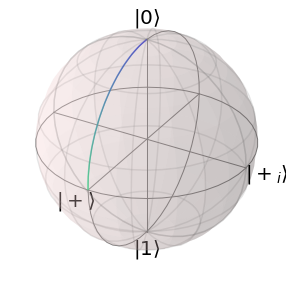

In [6]:
x_pi_half_gate_pulse = np.zeros(shape=(n_time_steps, 2), dtype=float)
x_pi_half_gate_pulse[:, 0] = .25 * np.pi / (n_time_steps * delta_t)
x_pi_half_gate_pulse[:, 1] = .5 * np.pi
solver.set_optimization_parameters(x_pi_half_gate_pulse)
solver.plot_bloch_sphere()


To get interesting filter functions, we generate a random pulse:

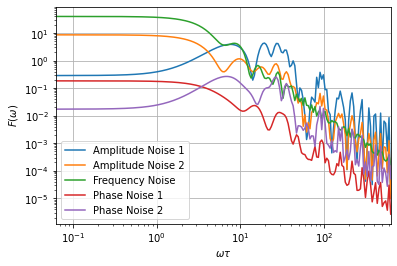

In [7]:
np.random.seed(4)
random_pulse = np.zeros(shape=(n_time_steps, 2), dtype=float)
random_pulse[:, 0] = np.random.rand(n_time_steps) * np.pi / (n_time_steps * delta_t)
random_pulse[:, 1] = 1 * np.random.rand(n_time_steps) * np.pi

solver.create_pulse_sequence(random_pulse)
pulse_sequence = solver.pulse_sequence
omega = ff.util.get_sample_frequencies(
    pulse_sequence, n_samples=200, spacing='log')
_ = ff.plotting.plot_filter_function(pulse_sequence, omega, yscale='log')

Now we define a noise spectral density. In our model, we assume that the
amplitude is subjected to $1/f$ type noise, the phase is subjected to white noise
and the frequency is subjected to $1/f^2$ noise.

We verify that everything is set up correctly by calculating the cost functions
and compare the analytic to numeric derivatives calculated by finite
differences.

In [8]:
def psd(f):
    spectral_power_density = np.zeros(shape=[5, f.shape[0]], dtype=float)
    # 1/f noise on the amplitudes
    spectral_power_density[0, :] = .01 / f
    spectral_power_density[1, :] = .01 / f
    # white noise on the phase
    spectral_power_density[2, :] = .1
    spectral_power_density[3, :] = .1
    # 1/f^2 noise on the frequency
    spectral_power_density[4, :] = .0001 / f ** 2
    return spectral_power_density

ff_infidelity = OperatorFilterFunctionInfidelity(
    solver=solver,
    noise_power_spec_density=psd,
    omega=omega
)

target_gate = DenseOperator.pauli_x().exp(-1j * .25 * np.pi)
coherent_infid = OperationInfidelity(
    solver=solver,
    target=target_gate
)

simulator = Simulator(
    solvers=[solver, ],
    cost_funcs=[coherent_infid, ff_infidelity]
)
print('Infidelities calculated with filter function:')
print(simulator.wrapped_cost_functions(random_pulse))
print('Absolute and relative deviation of analytic and numeric gradients.')
print(simulator.compare_numeric_to_analytic_gradient(random_pulse))

Infidelities calculated with filter function:
[0.81526447 0.00651779 0.02648523 0.00099263 0.00440001 0.04920558]
Absolute and relative deviation of analytic and numeric gradients.
(3.677573019019407e-08, 1.9981015783347852e-08)


In a last step, we can start an optimization. We set the cost_func_weights
to give the infidelitites calculated with the filter functions a higher weight
of two orders of magnitude. This is sometimes necessary to avoid, that the
optimizer simply optimizes the coherent dynamics and then gets stuck in a local
optimum.

<AxesSubplot:xlabel='Iteration', ylabel='Costs'>

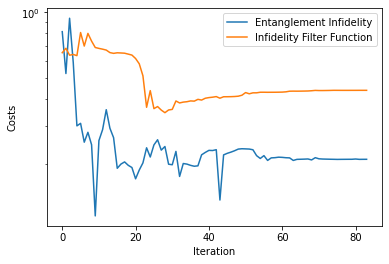

In [10]:
optimizer = ScalarMinimizingOptimizer(
    system_simulator=simulator,
    cost_func_weights=[1, 1e2, 1e2, 1e2, 1e2, 1e2]
)

result = optimizer.run_optimization(random_pulse)

data_container = DataContainer()
data_container.append_optim_result(result)
analyser = Analyser(data_container)
analyser.plot_costs()

In a last step, we restart the optimization without weights to calibrate
coherent errors. As initial pulse, we use the optimized pulse from the last
optimization.

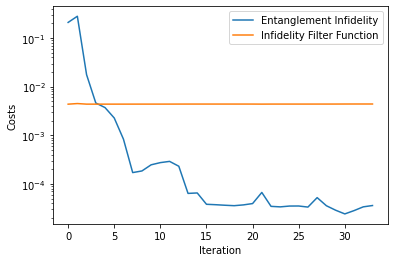

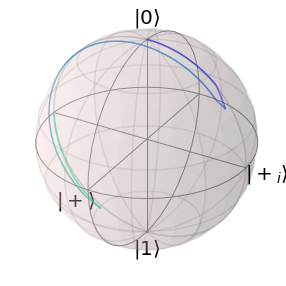

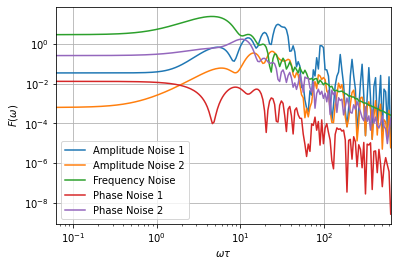

In [11]:
optimizer.cost_func_weights = None
result_2 = optimizer.run_optimization(result.final_parameters)
data_container.append_optim_result(result_2)
analyser.plot_costs(n=1)

solver.plot_bloch_sphere(result_2.final_parameters)
solver.create_pulse_sequence(result_2.final_parameters)
pulse_sequence = solver.pulse_sequence
_ = ff.plotting.plot_filter_function(pulse_sequence, omega, yscale='log')